Look at an appropriate RNN architecture and how to feed it the data.

In [1]:
# Helper Functions
def normalize(train):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    return train, mean, std

def normalize_with_paras(test, mean, std):
    test = (test - mean) / std
    return test

def binary_metrics(confusion):
    if confusion.shape != (2,2):
        return {'precision':-1, 'recall':-1, 'f1_score':-1, 'accuracy':-1}
    
    tp = confusion[0][0]
    fn = confusion[0][1]
    fp = confusion[1][0]
    tn = confusion[1][1]
    
    metrics = {}
    metrics['f1_score'] = (2.0*tp)/(2.0*tp+fp+fn)
    metrics['precision'] = float(tp)/(tp+fp)
    metrics['recall'] = float(tp)/(tp+fn)
    metrics['accuracy'] = float(tp+tn)/(tp+tn+fp+fn)
    
    return metrics

def next_batch(data, labels, current_batch, batch_size):
    start_idx = current_batch * batch_size
    end_idx = (current_batch + 1)*batch_size
    current_batch += 1
    return (current_batch, data[start_idx:end_idx], labels[start_idx:end_idx] )

In [2]:
# Data Preparation
import numpy as np
import os
mel_directory = r'/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5/'
X_train = np.load(os.path.join(mel_directory,"161225-002.wav-mel.npy")).astype(float).transpose(0,2,1)
y_train = np.load(os.path.join(mel_directory,"161225-002-mel-labels.npy")).astype(int) #.reshape((-1,1))
X_test = np.load(os.path.join(mel_directory,"161225-003.wav-mel.npy")).astype(float).transpose(0,2,1)
y_test = np.load(os.path.join(mel_directory,"161225-003-mel-labels.npy")).astype(int) #.reshape((-1,1))
X_train, mean, std = normalize(X_train)
X_test = normalize_with_paras(X_test, mean, std)

In [3]:
X_train.shape

(4792, 351, 40)

In [4]:
y_train.shape

(4792,)

In [5]:
# Baseline accuracy i.e. always choose the most frequent class
100-(100.0*np.sum(y_test)/y_test.shape[0])

98.18379949146386

In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import GRUCell
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()

n_inputs = 40
n_steps = 351

n_neurons = 32
n_layers = 2
n_fully_connected = 64
n_outputs = 2

learning_rate = 0.001
keep_prob = 1.0

epsilon = 0.00000001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # n_steps is the number of time steps
y = tf.placeholder(tf.int64, [None])

# RNN(GRU) layer
with tf.name_scope('rnn'):
    with tf.contrib.framework.arg_scope(
        [ fully_connected],
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
        
        cells=[]
        for _ in range(n_layers):
            cell = tf.contrib.rnn.DropoutWrapper(GRUCell(num_units=n_neurons), input_keep_prob=keep_prob)
            cells.append(cell)
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=False)        
        outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
        FC_1_logits = fully_connected(states, n_fully_connected)
        logits = fully_connected(FC_1_logits, n_outputs, activation_fn=None)

# cost function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)

# Gradient decent optimiser
with tf.name_scope('train'):    
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimiser.minimize(loss)

# evaluation using accuracy
with tf.name_scope('eval'):
    proba = tf.nn.softmax(logits, name='proba')
    predicted = tf.arg_max(proba,1)
    confusion = tf.confusion_matrix(labels=y, predictions=predicted)

    actual = y

    tp = tf.to_float(tf.count_nonzero(predicted * actual))
    tn = tf.to_float(tf.count_nonzero((predicted - 1) * (actual - 1)))
    fp = tf.to_float(tf.count_nonzero(predicted * (actual - 1)))
    fn = tf.to_float(tf.count_nonzero((predicted - 1) * actual))
    

    precision = tp /(tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    
    precision_summary = tf.summary.scalar('precision',precision)
    recall_summary = tf.summary.scalar('recall',recall)
    f1_summary = tf.summary.scalar('f1',f1)
    
    tp_summary = tf.summary.scalar('tp',tp)
    fp_summary = tf.summary.scalar('fp',fp)

    tn_summary = tf.summary.scalar('tn',tn)
    fn_summary = tf.summary.scalar('fn',fn)

    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) 
    
n_epochs = 100
batch_size = 154

saver = tf.train.Saver()

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    best_f1 = -1
    
    for epoch in range(n_epochs):
        current_batch = 0
        for iteration in range(X_train.shape[0] // batch_size):
            current_batch, X_batch, y_batch = next_batch(X_train, y_train, current_batch, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 10 == 0:
                logits_vals = logits.eval(feed_dict={X: X_batch, y: y_batch})
                summary_tp_str = tp_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_tn_str = tn_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_fp_str = fp_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_fn_str = fn_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_precision_str = precision_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_recall_str = recall_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                summary_f1_str = f1_summary.eval(feed_dict={logits:logits_vals, y: y_batch})
                
                step = epoch * (X_train.shape[0] // batch_size) + iteration
                file_writer.add_summary(summary_tp_str, step)
                file_writer.add_summary(summary_tn_str, step)
                file_writer.add_summary(summary_fp_str, step)
                file_writer.add_summary(summary_fn_str, step)
                file_writer.add_summary(summary_precision_str, step)
                file_writer.add_summary(summary_recall_str, step)
                file_writer.add_summary(summary_f1_str, step)

        pred_train = predicted.eval(feed_dict={X: X_train, y: y_train})
        pred_test = predicted.eval(feed_dict={X: X_test, y: y_test})
        logits_train = logits.eval(feed_dict={X:X_train,y:y_train})
        logits_test = logits.eval(feed_dict={X:X_test,y:y_test})
        confusion_train = confusion.eval(feed_dict={logits: logits_train, y: y_train})
        confusion_test = confusion.eval(feed_dict={logits: logits_test, y: y_test})
        
        tp_val_test = tp.eval(feed_dict={predicted:pred_test, actual:y_test})
        tn_val_test = tn.eval(feed_dict={predicted:pred_test, actual:y_test})
        fp_val_test = fp.eval(feed_dict={predicted:pred_test, actual:y_test})
        fn_val_test = fn.eval(feed_dict={predicted:pred_test, actual:y_test})
        prec_val_test = precision.eval(feed_dict={tp:tp_val_test,fp:fp_val_test})
        rec_val_test = recall.eval(feed_dict={tp:tp_val_test,fn:fn_val_test})
        f1_score_test = f1.eval(feed_dict={precision:prec_val_test, recall:rec_val_test})
              
        print(epoch, "f1 test score:",f1_score_test)
        print("Train Confusion Matrix:")
        print(confusion_train)
        print("Test Confusion Matrix:")
        print(confusion_test)

        # Save best model so far
        if f1_score_test > best_f1:
            save_path = saver.save(sess, './my_model_final.ckpt')
            best_f1 = f1_score_test
            
    file_writer.close()

(0, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(1, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(2, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(3, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(4, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(5, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(6, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(7, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[4692    0]
 [ 100    0]]
Test Confusion Matrix:
[[5

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    logits_vals = logits.eval(feed_dict={X:X_train[4500:4600],y:y_train[4500:4600]})
    y_vals = y.eval(feed_dict={y: y_train[4500:4600]})
    pred = predicted.eval(feed_dict={X:X_train[4500:4600],y:y_train[4500:4600]})
    tp_val = tp.eval(feed_dict={predicted:pred, actual:y_vals})
    tn_val = tn.eval(feed_dict={predicted:pred, actual:y_vals})
    fp_val = fp.eval(feed_dict={predicted:pred, actual:y_vals})
    fn_val = fn.eval(feed_dict={predicted:pred, actual:y_vals})
    confus = confusion.eval(feed_dict={logits:logits_vals, y: y_vals})
    prec_val = precision.eval(feed_dict={tp:tp_val,fp:fp_val})
    rec_val = recall.eval(feed_dict={tp:tp_val,fn:fn_val})
    f1_score = f1.eval(feed_dict={precision:prec_val, recall:rec_val})
    print(y_vals)
    print(pred)
    print(tp_val)
    print(tn_val)
    print(fp_val)
    print(fn_val)
    print(confus)
    print(prec_val)
    print(rec_val)
    print(f1_score)

# Generate a Prediction from a Saved Model

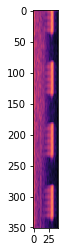

('Label:', 1)
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
prediction: 1


In [34]:
# look at an example input
from matplotlib import pyplot as plt
i = 5100
plt.imshow(X_test[i], cmap=plt.cm.magma)
plt.show()
print('Label:',y_test[i])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    pred = predicted.eval(feed_dict={X:X_test[i].reshape(1,n_steps,n_inputs)})
    print('prediction: %i'%pred)


# TODOs
* Hyper parameter tuning
* More test data
* Augment data with copies of beeps